# Caso práctico 3 - Clasificación y Modelado de Temas

## Libraries & Misc

In [3]:
# !pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from tqdm import tqdm
import re  # Importar el módulo re
import os

tqdm.pandas()

### Directorios

In [5]:
dir = 'data/'
raw_dir = 'raw/'
processed_dir = 'processed/'
test_dir = 'test/'
train_dir = 'train/'

## Data Loading

Esta función nos permite cargar todos los ficheros .txt que tenemos y asignarlo a una tabla con el formato de:

id | category | train | corpus

en la que representan lo siguiente:
- **id**: representa el nombre del fichero .txt.
- **category**: la categoría que pertenece el fichero (business, sport, ...).
- **train**: si el fichero pertenece al conjunto preseparado de train o de test.
- **corpus**: el corpus del contenido del fichero .txt.


In [6]:
def load_data(base_dir):
    df = pd.DataFrame(columns=['id', 'category', 'train', 'corpus'])
    err = ''
    try:
        for train_test_dir in os.listdir(base_dir):
            for cat_dir in os.listdir(base_dir + train_test_dir):
                for text_file in os.listdir(base_dir + train_test_dir + '/' + cat_dir):
                    file_name = base_dir + train_test_dir + '/' + cat_dir + '/' + text_file
                    with open(base_dir + train_test_dir + '/' + cat_dir + '/' + text_file, 'r', encoding='utf-8', errors='replace') as file:
                        text = file.read()
                        # print(text)
                        # print('----------------------')
                        df.loc[len(df)] = {'id': text_file, 'category': cat_dir, 'train': train_test_dir, 'corpus': text}
                    print

        return df

    except Exception as e:
        print(e)
        print(file_name)

Hacemos un pequeño cambio a la columna train porque como guarda los nombres de los directorios, en la columna train lo guarda como los nombre de los directorios. Debido a esto, en vez de tene valores 1 o 0, nos aparece el nombre del directorio, por lo que nos dificultará el procesamiento posterior.

In [7]:
# change df[train] values to 1 or 0 depending if it is bbc_train or bbc_test respectively
def change_train_to_int(df):
    df['train'] = df['train'].apply(lambda x: 1 if x == 'bbc-train' else 0)
    return df

Guardamos el df en fichero para no tener que realizar el procesamiento todas las veces

In [8]:
df = load_data(dir + raw_dir)
df = change_train_to_int(df)
os.makedirs(dir + processed_dir, exist_ok=True)
df.to_csv(dir + processed_dir + 'df_raw', index=False)

In [9]:
df = pd.read_csv(dir + processed_dir + 'df_raw')

In [10]:
df.head(3)

,id,category,train,corpus
0,024.txt,business,0,US trade gap hits record in 2004\n\nThe gap be...
1,025.txt,business,0,Yukos loses US bankruptcy battle\n\nA judge ha...
2,026.txt,business,0,Safety alert as GM recalls cars\n\nThe world's...


## EDA

### Distribuciones de datos

Hacemos inicialmente un estudio de distribución de los datos y se observa lo siguiente:
* La distribución de la columna categoría tiene una distribución bastante uniforme y balanceada.
* El ratio de train test pre separado es de 90:10 aproximadamente.

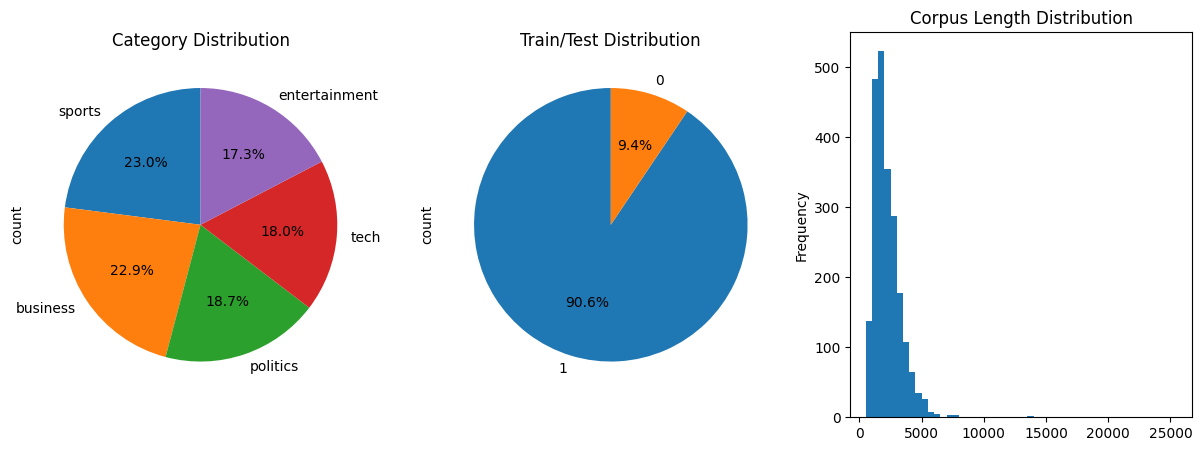

In [11]:
# plot category distribution as pie chart of columns category, train and len(corpus)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df['category'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, title='Category Distribution')
df['train'].value_counts().plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, title='Train/Test Distribution')
df['len'] = df['corpus'].apply(len)
df['len'].plot.hist(ax=ax[2], bins=50, title='Corpus Length Distribution')
plt.show()

Ahora realizamos el mismo proceso pero separando en los conjuntos train y test, para ver si la distribución varía entre estas.

C:\Users\NoobG\AppData\Local\Temp\ipykernel_28768\3329944406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['train']==1]['len'] = df['corpus'].apply(len)


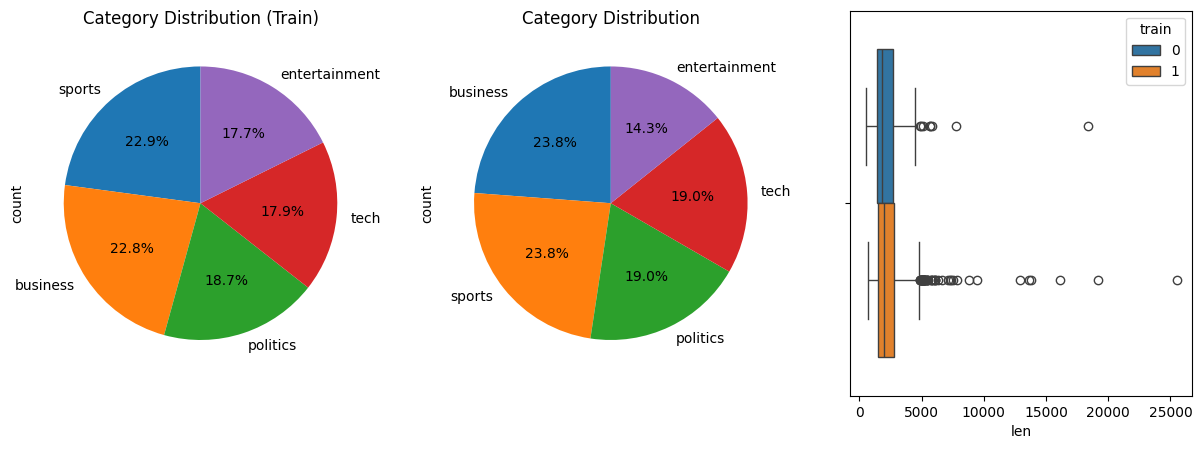

In [12]:
# plot category distribution as pie chart of columns category, train and len(corpus) but filtering by the train column
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df[df['train']==1]['category'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, title='Category Distribution (Train)')
df[df['train']==0]['category'].value_counts().plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, title='Category Distribution')
df[df['train']==1]['len'] = df['corpus'].apply(len)
# df[df['train']==1]['len'].plot.hist(ax=ax[2], bins=50, title='Corpus Length Distribution', hue='Train')
sns.boxplot(data=df, x='len', hue='train')
plt.show()

Se observa que las distribuciones se mantienen más o menos constante, en tanto las categorías como las longitudes de corpus de manera general.

Ahora comprobaremos las longitudes de las diferentes categorías

<Axes: xlabel='len', ylabel='category'>

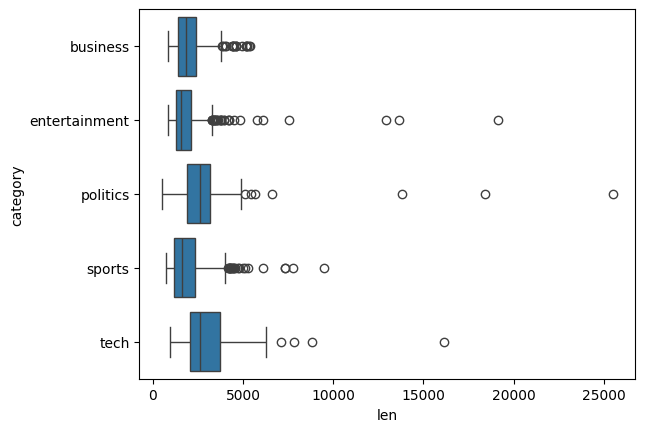

In [13]:
sns.boxplot(data=df, x='len', y='category')

Se observa que a pesar de que a pesar de que en grandes rasgos tienen un rango similar, si nos fijamos detalladamente, se puede observarq ue si que hay una diferencia más notable. Esto se observa precisamente en caso de tech que tiene en media y en rango IQR, mayor longitud que los de deporte, entretenimiento y business.

### Conclusión (EDA)

Hemos visto en el apartado de EDA que no hay desbalance significativo aparte de la diferencia en la longitud de las oraciones.

Nota: Las longitudes son de corpus absoluto, lo cual incluye espacios, "\n" entre otros caracteres especiales. Pero esto nos sirve para tener un conocimiento aproximado.

## Preprocessing

### Libraries

In [14]:
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression  # Ejemplo de clasificador
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C:\Users\NoobG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cleaning

Utilizamos la libreria de spacy para limpiar el texto y obtener los tokens.

Esta función lo que hace es mediante el uso de la libreria spacy, filtramos los tokens (palabras o elementos) que sean stop words, signos de puntuación (signos monetarios) y espacios.

Mantenemos los casos los signos monetarios porque podría dar más información del contexto del topic.

In [35]:
nlp = spacy.load("en_core_web_sm")  # Usa 'en_core_web_md' o 'en_core_web_lg' para modelos más grandes

def tokenizer(text):
    """
    Limpia un texto
    """
    doc = nlp(text)

    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

    return tokens

In [36]:
def token_to_corpus(token_list):
    """
    Convierte una lista de tokens en un texto
    """
    return " ".join(token_list)

In [37]:
df['tokens'] = df['corpus'].progress_apply(tokenizer)

100%|██████████| 2225/2225 [02:32<00:00, 14.59it/s]


In [38]:
df['corpus'] = df['tokens'].progress_apply(token_to_corpus)

100%|██████████| 2225/2225 [00:00<00:00, 106045.55it/s]


In [39]:
df['corpus'][0]

'trade gap hit record 2004 gap export import hit time high $ 671.7bn £ 484bn 2004 late figure commerce department say trade deficit year 24.4 previous record 2003 imbalance $ 496.5bn deficit china 30.5 $ 162bn large record single country monthly basis trade gap narrow 4.9 december £ 56.4bn consumer appetite thing oil import car wine cheese reach record level year figure likely spark fresh criticism president bush economic policy democrats claim administration clamp unfair foreign trade practice example believe china currency policy manufacturer claim undervalue yuan 40 give china rapidly expand economy unfair advantage competitor bush administration argue deficit reflect fact america grow fast rate rest world spur demand import good economist allow upward revision economic growth fourth quarter point deficit reach astronomical proportion foreigner choose hold dollar denominate asset turn harm growth 2004 export rise 12.3 $ 1.15 trillion import rise fast 16.3 new record $ 1.76 trillion 

In [40]:
df['tokens'][0]

['trade',
 'gap',
 'hit',
 'record',
 '2004',
 'gap',
 'export',
 'import',
 'hit',
 'time',
 'high',
 '$',
 '671.7bn',
 '£',
 '484bn',
 '2004',
 'late',
 'figure',
 'commerce',
 'department',
 'say',
 'trade',
 'deficit',
 'year',
 '24.4',
 'previous',
 'record',
 '2003',
 'imbalance',
 '$',
 '496.5bn',
 'deficit',
 'china',
 '30.5',
 '$',
 '162bn',
 'large',
 'record',
 'single',
 'country',
 'monthly',
 'basis',
 'trade',
 'gap',
 'narrow',
 '4.9',
 'december',
 '£',
 '56.4bn',
 'consumer',
 'appetite',
 'thing',
 'oil',
 'import',
 'car',
 'wine',
 'cheese',
 'reach',
 'record',
 'level',
 'year',
 'figure',
 'likely',
 'spark',
 'fresh',
 'criticism',
 'president',
 'bush',
 'economic',
 'policy',
 'democrats',
 'claim',
 'administration',
 'clamp',
 'unfair',
 'foreign',
 'trade',
 'practice',
 'example',
 'believe',
 'china',
 'currency',
 'policy',
 'manufacturer',
 'claim',
 'undervalue',
 'yuan',
 '40',
 'give',
 'china',
 'rapidly',
 'expand',
 'economy',
 'unfair',
 'advant

### Analisis con Word Cloud

Ahora que tenemos los elementos tokenizados, vamos a hacer un análisis con word cloud para ver la frecuencia y relevancia de las palabras en el corpus.

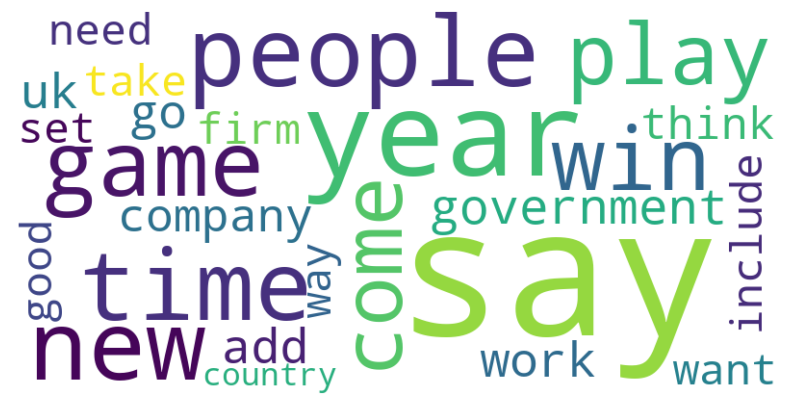

In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# all_tokens es la lista aplanada de todos los tokens (ya limpios)

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=25)
wordcloud.generate(" ".join(df['tokens'].sum()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()